In [1]:
from rdkit.Chem import AllChem, MolFromSmiles, MolToSmiles, Draw
from rdkit.Chem.rdmolops import FastFindRings

from rdkit import Chem
from tqdm import tqdm
import pandas as pd
import numpy as np

RDKit WARNING: [22:51:11] Enabling RDKit 2019.09.3 jupyter extensions


# Example Molecule

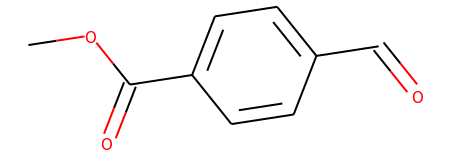

In [2]:
from rdkit.Chem.Draw import IPythonConsole

df = pd.read_csv('test.smiles')
mols = [MolFromSmiles(smi) for smi in df['SMILES'].values]
for m in mols: tmp=AllChem.Compute2DCoords(m)
mols[0]

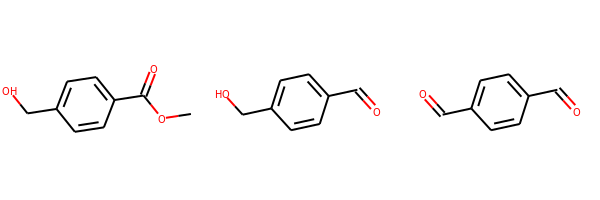

In [3]:
aldehyde_to_alcohol = AllChem.ReactionFromSmarts('[CX3H1:1](=[O:2]) >> [CX3H1:1][OX2H1:2]')
ester_to_aldehyde = AllChem.ReactionFromSmarts('[CX3:1](=[O:2])[OX2H0][CX4] >> [CX3H1:1](=[O:2])')
ester_to_alcohol = AllChem.ReactionFromSmarts('[CX3:1](=[O:2])[OX2H0][CX4] >> [CX3H2:1][OX2H1:2]')

alcohol1 = aldehyde_to_alcohol.RunReactants((mols[0],))[0][0]
alcohol2 = ester_to_alcohol.RunReactants((mols[0],))[0][0]
aldehydes = ester_to_aldehyde.RunReactants((mols[0],))[0][0]

products = [alcohol1,alcohol2,aldehydes]
for m in products: 
    tmp=AllChem.Compute2DCoords(m)
    m.UpdatePropertyCache()
    FastFindRings(m) #sanitation
img = Draw.MolsToGridImage(products, molsPerRow=3)
img

# Some useful functions for enumerating reactions

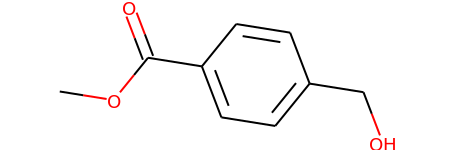

In [4]:
def sanitize(mol):
    tmp=AllChem.Compute2DCoords(mol)
    mol.UpdatePropertyCache()
    FastFindRings(mol) #sanitation

def simple_rxn(mol_list, rxn, debug=False):
    prod_list = []
    for mol in mol_list:
        if debug:
            print('Input: '+ MolToSmiles(mol))
        products = rxn.RunReactants((Chem.AddHs(mol),))
        if debug:
            print('Products: {}'.format(products))
        if products != ():
            for prod in products:
                if debug:
                    logging.info(prod)
                    logging.info(MolToSmiles(Chem.RemoveHs(prod[0])))
                # prod_list.append(MolToSmiles(prod[0]))
                output = prod[0]
                sanitize(output)
                
                prod_list.append(Chem.RemoveHs(output))
    return prod_list

alcohol = simple_rxn(mols, aldehyde_to_alcohol)
alcohol[0]

# Toy dataset from ZINC
First, load the dataset and choose 10000 random molecules

In [5]:
import random
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol, MakeScaffoldGeneric

df = pd.read_csv('zinc_250k.smi')
smiles_list = list(df['SMILES'].values) # random.sample complains if I don't put list() around this
uniq_mols = random.sample(smiles_list, 100000)

Then we generate all-carbon scaffolds from those molecules

Number of uniq scaffolds: 26421


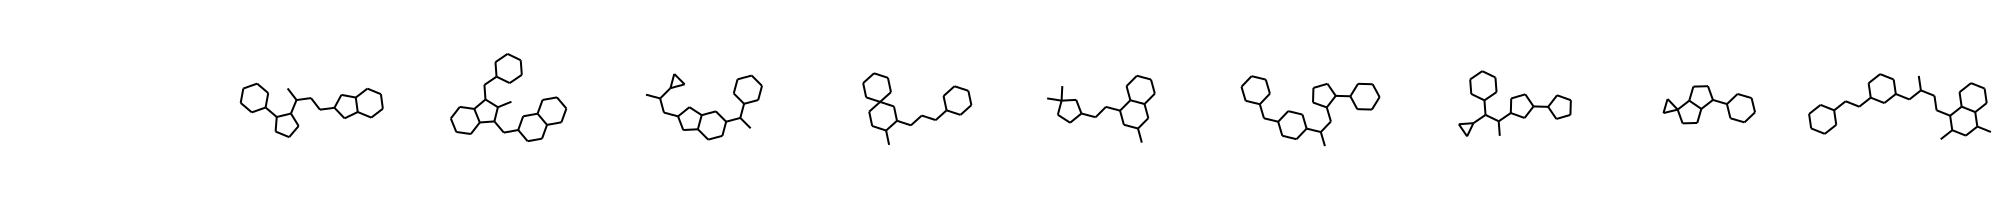

In [6]:
uniq_scaffs = []
for smi in uniq_mols:
    scaffold = GetScaffoldForMol(MolFromSmiles(smi))
    scaffold = MakeScaffoldGeneric((scaffold))
    uniq_scaffs.append(MolToSmiles(scaffold))
uniq_scaffs = list(set(uniq_scaffs))
print('Number of uniq scaffolds: {}'.format(len(uniq_scaffs)))
uniq_scaffs = [MolFromSmiles(smi) for smi in uniq_scaffs]
img = Draw.MolsToGridImage(uniq_scaffs[:10], molsPerRow=10)
img

Next, we randomly add aldehydes and methyl esters to sp3 carbons with 2 hydrogens

Number of aldehydes: 26419
Number of esters: 26419
Number of both: 26419


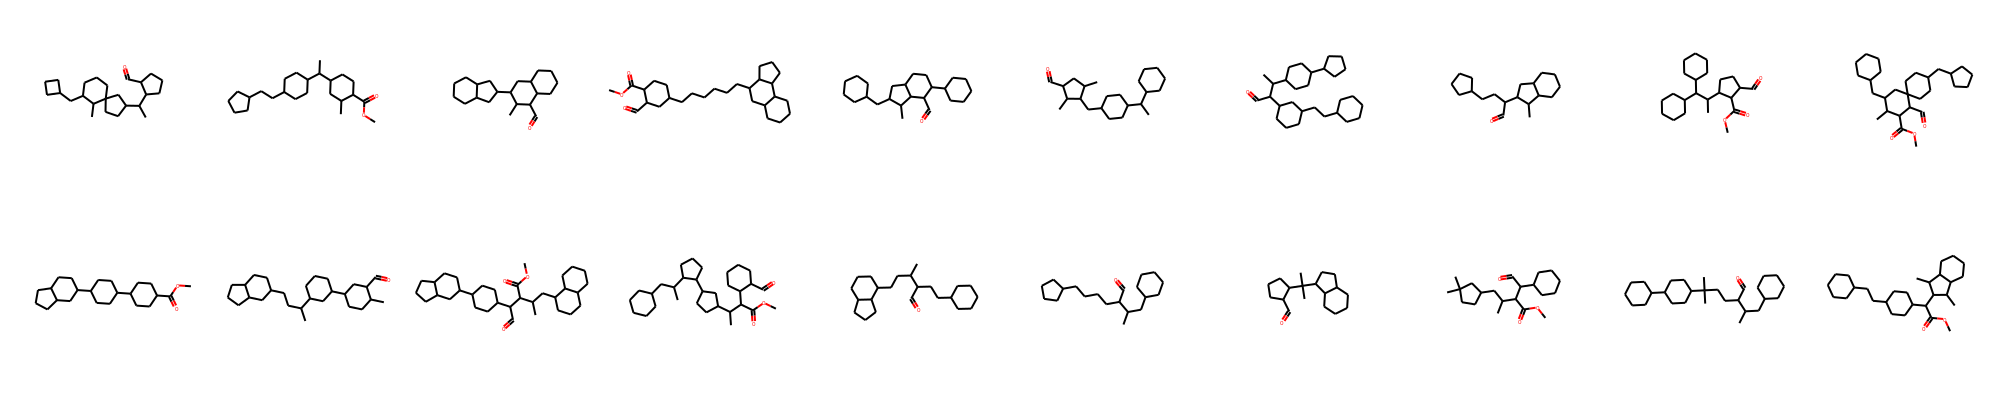

In [7]:
add_aldehyde = AllChem.ReactionFromSmarts('[CX4H2:1] >> [CX4H1:1][CX3H1](=O)')
add_ester = AllChem.ReactionFromSmarts('[CX4H2:1] >> [CX4H1:1][CX3](=[O])[OX2H0][CX4]')

aldehydes = []
esters = []
both_list = []
#test = uniq_scaffs[:5]
#for input in test:
for input in uniq_scaffs:
    try:
        aldehyde = add_aldehyde.RunReactants((input,))[0][0]
        sanitize(aldehyde)
        aldehydes.append(aldehyde)
        ester = add_ester.RunReactants((input,))[0][0]
        sanitize(ester)
        esters.append(ester)
        both = add_aldehyde.RunReactants((ester,))[0][0]
        sanitize(both)
        both_list.append(both)
    except:
        continue
print('Number of aldehydes: {}'.format(len(aldehydes)))
print('Number of esters: {}'.format(len(esters)))
print('Number of both: {}'.format(len(both_list)))
products = aldehydes + esters + both_list
img = Draw.MolsToGridImage(random.sample(products,20), molsPerRow=10)
img

Finally, apply the aldehyde and ester reductions to construct separate lists of reaction SMILES for NaBH4, DIBAL, and LiAlH4 reactions - the three lists are concatenated and written to `toy_rxns.txt`

In [8]:
# 300 NaBH4 - aldehyde to alcohol (200 aldehydes, 100 both)
# 300 DIBAL - ester to aldehyde (200 esters, 100 both)
# 300 LiAlH4 - both to alcohol (100 aldehydes, 100 esters, 100 both)

NaBH4 = '[B+3].[H-].[H-].[H-].[H-].[Na+]'
LiAlH4 = '[Al+3].[H-].[H-].[H-].[H-].[Li+]'
DIBAL = 'CC(C)C[AlH]CC(C)C'

#NaBH4
inputs = random.sample(aldehydes, 20000) + random.sample(both_list, 10000)
alcohols = simple_rxn(inputs, aldehyde_to_alcohol)
NaBH4_rxns = []
for i, mol in enumerate(alcohols):
    rxn = MolToSmiles(inputs[i])+'.'+NaBH4+'>>'+MolToSmiles(mol)
    NaBH4_rxns.append(rxn)


# img = Draw.MolsToGridImage(inputs, molsPerRow=10)
# img.show()
# raise Exception
# img = Draw.MolsToGridImage(alcohols, molsPerRow=10)
# img.show()
    
#DIBAL
inputs = random.sample(esters, 20000) + random.sample(both_list, 10000)
alds = simple_rxn(inputs, ester_to_aldehyde)
DIBAL_rxns = []
for i, mol in enumerate(alds):
    rxn = DIBAL+'.'+MolToSmiles(inputs[i])+'>>'+MolToSmiles(mol)
    DIBAL_rxns.append(rxn)
    
#LiAlH4
inputs = random.sample(esters,10000)
alcohols1 = simple_rxn(inputs, ester_to_alcohol)
LiAlH4_rxns = []
for i, mol in enumerate(alcohols1):
    rxn = MolToSmiles(inputs[i])+'.'+LiAlH4+'>>'+MolToSmiles(mol)
    LiAlH4_rxns.append(rxn)
inputs = random.sample(aldehydes, 10000)
alcohols2 = simple_rxn(inputs, aldehyde_to_alcohol)
for i, mol in enumerate(alcohols2):
    rxn = MolToSmiles(inputs[i])+'.'+LiAlH4+'>>'+MolToSmiles(mol)
    LiAlH4_rxns.append(rxn)
inputs = random.sample(both_list, 10000)
alcohols3 = simple_rxn(inputs, aldehyde_to_alcohol)
alcohols3 = simple_rxn(alcohols3, ester_to_alcohol)
for i, mol in enumerate(alcohols3):
    rxn = MolToSmiles(inputs[i])+'.'+LiAlH4+'>>'+MolToSmiles(mol)
    LiAlH4_rxns.append(rxn)
    
all_rxns = NaBH4_rxns + DIBAL_rxns + LiAlH4_rxns
with open('toy_rxns_big2.txt', 'w') as filehandle:
    filehandle.writelines("%s\n" % rxn for rxn in all_rxns)
print('Toy dataset generated! {} reactions in total'.format(len(all_rxns)))

Toy dataset generated! 90000 reactions in total


In [9]:
from sklearn.model_selection import train_test_split

NaBH4_train, NaBH4_test = train_test_split(NaBH4_rxns, test_size=0.1)
NaBH4_train, NaBH4_val = train_test_split(NaBH4_train, test_size=0.11111)
DIBAL_train, DIBAL_test = train_test_split(DIBAL_rxns, test_size=0.1)
DIBAL_train, DIBAL_val = train_test_split(DIBAL_train, test_size=0.11111)
LiAlH4_train, LiAlH4_test = train_test_split(LiAlH4_rxns, test_size=0.1)
LiAlH4_train, LiAlH4_val = train_test_split(LiAlH4_train, test_size=0.11111)

train_set = NaBH4_train + DIBAL_train + LiAlH4_train
val_set = NaBH4_val + DIBAL_val + LiAlH4_val
test_set = NaBH4_test + DIBAL_test + LiAlH4_test

with open('train_big2.txt', 'w') as filehandle:
    filehandle.writelines("%s\n" % rxn for rxn in train_set)
with open('val_big2.txt', 'w') as filehandle:
    filehandle.writelines("%s\n" % rxn for rxn in val_set)
with open('test_big2.txt', 'w') as filehandle:
    filehandle.writelines("%s\n" % rxn for rxn in test_set)
print('splits generated!')

splits generated!
